# Predicting house sale prices
In this project we are going to practice implementing linear regression model to predict house sale prices.

We have a dataset which contains the information about house sales. We want to build a model that will predict the price based on some other characteristics of the houses.

Our pipeline will be as follows:

1. **Cleaning the dataset**. We want to save as much data as possible and after that we will choose features for predictions. The steps are:
    - to manage missing values
    - to edit data types, when it needs
    - to drop columns which can't be used for predictions
    - to manage categorical columns
    
2. **Creating a model** which will predict price based on choosen features: a linear regression model with given number of folds for training and testing as a parameter. As a start point we will use only one feature for predictions (we'll use Total Condition as it feels like the most correlated with the price). The result must be the mean RMSE and the standart deviation for RMSEs. 

3. **Making the hyperparameter optimization**. We'll try different k-value for the KFold validation

4. **Testing the model**. As a start point we will implement the model on 3 basic sets of features:
    - All numerical features
    - All avaliable features (both numerical and categorical)
    
5. **Experimenting with features**. At this stage we will try to encrease the performance of the model by choosing different combinations of features. The ideas are:
    - to choose the only features that correlate highly with the target field
    - to exclude features that highly correlate with each other
    - to decrease the number of categorical features (with high numbers of categories) 

In [1]:
import numpy as np
import pandas as pd

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

pd.options.display.max_columns = 999

In [2]:
houses = pd.read_csv('AmesHousing.tsv', delimiter = '\t')

In [3]:
houses.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2930 entries, 0 to 2929
Data columns (total 82 columns):
Order              2930 non-null int64
PID                2930 non-null int64
MS SubClass        2930 non-null int64
MS Zoning          2930 non-null object
Lot Frontage       2440 non-null float64
Lot Area           2930 non-null int64
Street             2930 non-null object
Alley              198 non-null object
Lot Shape          2930 non-null object
Land Contour       2930 non-null object
Utilities          2930 non-null object
Lot Config         2930 non-null object
Land Slope         2930 non-null object
Neighborhood       2930 non-null object
Condition 1        2930 non-null object
Condition 2        2930 non-null object
Bldg Type          2930 non-null object
House Style        2930 non-null object
Overall Qual       2930 non-null int64
Overall Cond       2930 non-null int64
Year Built         2930 non-null int64
Year Remod/Add     2930 non-null int64
Roof Style         29

## 1. Data cleaning
### 1.1. Dealing with nulls

We'll create a function which takes in a dataframe and returns the number of Null-values for each of its column

In [4]:
def get_nulls(df):
    null_df = pd.DataFrame({'types': df.dtypes,
                            'nulls': df.isnull().sum(),
                            'nulls_%': df.isnull().sum() / df.shape[0]*100})
    null_df = null_df[null_df['nulls']>0]
    return null_df

In [5]:
nulls_df = get_nulls(houses).sort_values('nulls', ascending=False)
nulls_df

,nulls,nulls_%,types
Pool QC,2917,99.556314,object
Misc Feature,2824,96.382253,object
Alley,2732,93.242321,object
Fence,2358,80.477816,object
Fireplace Qu,1422,48.532423,object
Lot Frontage,490,16.723549,float64
Garage Cond,159,5.426621,object
Garage Qual,159,5.426621,object
Garage Finish,159,5.426621,object
Garage Yr Blt,159,5.426621,float64


We see clearly there are TOP-6 columns. We'll drop them.

In [6]:
columns_to_drop = nulls_df[nulls_df['nulls_%']>15].index
houses.drop(columns=columns_to_drop, inplace=True)
nulls_df = get_nulls(houses)
nulls_df

,nulls,nulls_%,types
Mas Vnr Type,23,0.784983,object
Mas Vnr Area,23,0.784983,float64
Bsmt Qual,80,2.730375,object
Bsmt Cond,80,2.730375,object
Bsmt Exposure,83,2.832765,object
BsmtFin Type 1,80,2.730375,object
BsmtFin SF 1,1,0.034130,float64
BsmtFin Type 2,81,2.764505,object
BsmtFin SF 2,1,0.034130,float64
Bsmt Unf SF,1,0.034130,float64


Exploring garage-columns.

After exploring 7 columns that describe garages in different aspects, we can suggest, that the most useful characteristic is whether there is a garage and how many cars it can accomodate. So we can drop all columns except **'Garage Cars'**. But there are 1 missing value, which we must fix

In [7]:
houses['Garage Cars'].value_counts(dropna=False)

 2.0    1603
 1.0     778
 3.0     374
 0.0     157
 4.0      16
NaN        1
 5.0       1
Name: Garage Cars, dtype: int64

In [8]:
houses['Garage Cars'].fillna(0, inplace=True)
nulls_df = get_nulls(houses)
nulls_df

,nulls,nulls_%,types
Mas Vnr Type,23,0.784983,object
Mas Vnr Area,23,0.784983,float64
Bsmt Qual,80,2.730375,object
Bsmt Cond,80,2.730375,object
Bsmt Exposure,83,2.832765,object
BsmtFin Type 1,80,2.730375,object
BsmtFin SF 1,1,0.034130,float64
BsmtFin Type 2,81,2.764505,object
BsmtFin SF 2,1,0.034130,float64
Bsmt Unf SF,1,0.034130,float64


In [9]:
garage_nulls = nulls_df.index[nulls_df.index.str.contains(r'Garage')]
houses.drop(columns = garage_nulls, inplace=True)
nulls_df = get_nulls(houses)
nulls_df

,nulls,nulls_%,types
Mas Vnr Type,23,0.784983,object
Mas Vnr Area,23,0.784983,float64
Bsmt Qual,80,2.730375,object
Bsmt Cond,80,2.730375,object
Bsmt Exposure,83,2.832765,object
BsmtFin Type 1,80,2.730375,object
BsmtFin SF 1,1,0.034130,float64
BsmtFin Type 2,81,2.764505,object
BsmtFin SF 2,1,0.034130,float64
Bsmt Unf SF,1,0.034130,float64


Cleaning 'Basement' - columns

We have many columns that describe basements, but there is one that could be enough - total area of the basement. There are 1 missing value, that we must fill. After that we can drop all other columns that describe a basement

In [10]:
houses['Total Bsmt SF'].value_counts()

0.0       79
864.0     74
672.0     29
912.0     26
1040.0    25
768.0     24
816.0     23
728.0     21
780.0     19
384.0     19
1008.0    19
960.0     18
832.0     17
894.0     17
756.0     17
848.0     16
546.0     16
936.0     16
720.0     16
600.0     16
630.0     14
483.0     14
952.0     13
840.0     13
624.0     12
988.0     12
876.0     11
784.0     11
796.0     11
884.0     10
          ..
1768.0     1
1763.0     1
1157.0     1
1061.0     1
1777.0     1
1499.0     1
569.0      1
539.0      1
1230.0     1
968.0      1
656.0      1
1433.0     1
1910.0     1
1203.0     1
1645.0     1
1225.0     1
3094.0     1
2461.0     1
807.0      1
1210.0     1
1182.0     1
3206.0     1
869.0      1
1522.0     1
1907.0     1
811.0      1
1958.0     1
1615.0     1
1765.0     1
1967.0     1
Name: Total Bsmt SF, Length: 1058, dtype: int64

In [11]:
houses['Total Bsmt SF'].fillna(0, inplace=True)
nulls_df = get_nulls(houses)
nulls_df

,nulls,nulls_%,types
Mas Vnr Type,23,0.784983,object
Mas Vnr Area,23,0.784983,float64
Bsmt Qual,80,2.730375,object
Bsmt Cond,80,2.730375,object
Bsmt Exposure,83,2.832765,object
BsmtFin Type 1,80,2.730375,object
BsmtFin SF 1,1,0.034130,float64
BsmtFin Type 2,81,2.764505,object
BsmtFin SF 2,1,0.034130,float64
Bsmt Unf SF,1,0.034130,float64


In [12]:
bsmt_nulls = nulls_df.index[nulls_df.index.str.contains(r'Bsmt')]
bsmt_nulls
houses.drop(columns=bsmt_nulls, inplace=True)
get_nulls(houses)

,nulls,nulls_%,types
Mas Vnr Type,23,0.784983,object
Mas Vnr Area,23,0.784983,float64
Electrical,1,0.034130,object


The *Mas Vnr Type* and *Mas Vnr Area* columns holds quite the same information, so we can drop one and fill anothers with the most popular value for each

In [13]:
houses['Mas Vnr Type'].value_counts(dropna=False)

None       1752
BrkFace     880
Stone       249
BrkCmn       25
NaN          23
CBlock        1
Name: Mas Vnr Type, dtype: int64

In [14]:
houses['Mas Vnr Type'].fillna('None', inplace=True)
houses.drop(columns=['Mas Vnr Area'], inplace=True)

In [15]:
houses['Electrical'].value_counts(dropna=False)

SBrkr    2682
FuseA     188
FuseF      50
FuseP       8
Mix         1
NaN         1
Name: Electrical, dtype: int64

In [16]:
houses['Electrical'].fillna('SBrkr', inplace=True)

In [17]:
get_nulls(houses)

,nulls,nulls_%,types


### 1.2. Cleaning numerical columns

The only numerical columns that are absolutely irrelevant as features are: **'Order'** and **'PID'**. We'll drop them

The only numerical column that reflests categories is **'MS SubClass'**. We'll convert it 

Some columns we can use for creating new features are: **'Year Built', 'Year Remod/Add', 'Yr Sold', 'Mo Sold'**. We'll create a couple of new features and drop the initial columns

In [18]:
houses['years_since_built'] = houses['Yr Sold'] - houses['Year Built']
houses['years_since_remod'] = houses['Yr Sold'] - houses['Year Remod/Add']

In [19]:
houses[houses['years_since_built']<0]

,Order,PID,MS SubClass,MS Zoning,Lot Area,Street,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Type,Exter Qual,Exter Cond,Foundation,Total Bsmt SF,Heating,Heating QC,Central Air,Electrical,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Garage Cars,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice,years_since_built,years_since_remod
2180,2181,908154195,20,RL,39290,Pave,IR1,Bnk,AllPub,Inside,Gtl,Edwards,Norm,Norm,1Fam,1Story,10,5,2008,2009,Hip,CompShg,CemntBd,CmentBd,Stone,Ex,TA,PConc,5095.0,GasA,Ex,Y,SBrkr,5095,0,0,5095,2,1,2,1,Ex,15,Typ,2,3.0,Y,546,484,0,0,0,0,17000,10,2007,New,Partial,183850,-1,-2


In [20]:
houses[houses['years_since_remod']<0]

,Order,PID,MS SubClass,MS Zoning,Lot Area,Street,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Type,Exter Qual,Exter Cond,Foundation,Total Bsmt SF,Heating,Heating QC,Central Air,Electrical,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Garage Cars,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice,years_since_built,years_since_remod
1702,1703,528120010,60,RL,16659,Pave,IR1,Lvl,AllPub,Corner,Gtl,NridgHt,Norm,Norm,1Fam,2Story,8,5,2007,2008,Gable,CompShg,VinylSd,VinylSd,None,Gd,TA,PConc,1582.0,GasA,Ex,Y,SBrkr,1582,570,0,2152,2,1,3,1,Gd,7,Typ,1,2.0,Y,0,368,0,0,0,0,0,6,2007,New,Partial,260116,0,-1
2180,2181,908154195,20,RL,39290,Pave,IR1,Bnk,AllPub,Inside,Gtl,Edwards,Norm,Norm,1Fam,1Story,10,5,2008,2009,Hip,CompShg,CemntBd,CmentBd,Stone,Ex,TA,PConc,5095.0,GasA,Ex,Y,SBrkr,5095,0,0,5095,2,1,2,1,Ex,15,Typ,2,3.0,Y,546,484,0,0,0,0,17000,10,2007,New,Partial,183850,-1,-2
2181,2182,908154205,60,RL,40094,Pave,IR1,Bnk,AllPub,Inside,Gtl,Edwards,PosN,PosN,1Fam,2Story,10,5,2007,2008,Hip,CompShg,CemntBd,CmentBd,Stone,Ex,TA,PConc,3138.0,GasA,Ex,Y,SBrkr,3138,1538,0,4676,3,1,3,1,Ex,11,Typ,1,3.0,Y,208,406,0,0,0,0,0,10,2007,New,Partial,184750,0,-1


In [21]:
houses.drop(columns=['Order', 'PID','Year Built', 'Year Remod/Add', 'Mo Sold'], inplace= True)
houses.drop(index=[2180, 1702, 2181], inplace= True)

houses['MS SubClass'] = houses['MS SubClass'].astype('category')

### 1.3. Unpivoting categorical columns
First we'll see how many unique values are there in each text column

In [22]:
obj_columns = houses.select_dtypes('object').columns
columns = []
unique_values = []
for col in obj_columns:
    houses[col] = houses[col].astype('category')
    unique_values.append(houses[col].nunique())
    columns.append(col)
unique_values_df = pd.DataFrame({'Column': columns,
                                 'Num_unique_values': unique_values})
unique_values_df.sort_values('Num_unique_values', 
                             ascending=False).reset_index(drop=True)

,Column,Num_unique_values
0,Neighborhood,28
1,Exterior 2nd,17
2,Exterior 1st,16
3,Sale Type,10
4,Condition 1,9
5,Condition 2,8
6,Functional,8
7,Roof Matl,8
8,House Style,8
9,MS Zoning,7


Now, we'll create a function, which unpivot all non-numerical columns or get **dummies**. The parameter **max_values** determines the maximum number of unique values in the column that will be unpivoted

In [23]:
def unpivot(df, max_values=28):    
    cat_columns = df.select_dtypes(['category']).columns
    extended_df = df.copy()
    for col in cat_columns:
        if df[col].nunique() <= max_values:
            extended_df = pd.concat([extended_df, pd.get_dummies(df[col])],
                                    axis=1)
        extended_df.drop(columns=col, inplace=True)
    return extended_df

## 2. Creating a model
The function should take the dataframe, and the number of folds we want to use for cross validation and return the mean RMSE value and the standart deviation for all RMSE values (if the number of folds id more than 2).

In [24]:
def train_and_test(df, num_folds = 2):
    numeric_df = df.select_dtypes(np.number)
    features = numeric_df.drop(columns='SalePrice').columns
    lr = LinearRegression()
        
    if num_folds < 2:    
        train = numeric_df.iloc[:1460] 
        test = numeric_df.iloc[1460:]   
        lr.fit(train[features], train['SalePrice'])
        predictions = lr.predict(test[features])
        mse = mean_squared_error(test['SalePrice'], predictions)
        rmse = np.sqrt(mse)
        rmses_std = None        
    else:
        kf = KFold(n_splits=num_folds,
                   shuffle=True,
                   random_state=1)
        
        mses = cross_val_score(lr,
                               numeric_df[features],
                               numeric_df['SalePrice'],
                               scoring='neg_mean_squared_error',
                               cv=kf                           
                              )        
        rmses = np.sqrt(np.abs(mses))
        rmse = np.mean(rmses)
        rmses_std = np.std(rmses)    
    return rmse, rmses_std

In [25]:
one_featured_df = houses[["Overall Qual", "SalePrice"]]
rmse, rmses_std = train_and_test(one_featured_df)
rmse, rmses_std

(47862.101668654745, 1062.885668590934)

## 3. Choosing the default number of folds for KFold validation

In [26]:
rmses = []
stds = []
folds = []
for k in range(1, 15):
    rmse, rmses_std = train_and_test(one_featured_df, k)
    rmses.append(rmse)
    stds.append(rmses_std)
    folds.append(k)
folds_df = pd.DataFrame({'Folds': folds,
                         'RMSE': rmses,
                         'Std': stds                     
                        })
folds_df

,Folds,RMSE,Std
0,1,49145.599010,NaN
1,2,47862.101669,1062.885669
2,3,47917.756702,1596.992081
3,4,47832.149612,2592.858527
4,5,47779.550055,3033.665342
5,6,47792.187491,3700.915235
6,7,47797.820504,2178.011471
7,8,47805.909538,2812.222737
8,9,47776.538276,2881.423046
9,10,47743.429752,3354.292904


We can see, that changing the number of folds doesn't affect much on RMSE, while StD changes much more. So, for now we can say **2** folds are the best choice

## 4.1. All numerical features
As a start point let's try to use all numerical features for predictions, and then try to choose only relevant ones

In [27]:
# We take all features before unpivoting categorical values

rmse_all_numeric = train_and_test(houses)
rmse_all_numeric

(33065.07537584398, 2419.592681484257)

## 4.2. All avaliable features

In [28]:
houses_extended = unpivot(houses)
rmse_all_avaliable = train_and_test(houses_extended)
rmse_all_avaliable

(29413.742142859708, 1312.3000532008646)

## 5. Feature engineering

It seems for now, that the more features are used the more performance we get. Let's see whether we can improve the performance by choosing only some set of features.

The first step is to choose only features that correlates with the target column most

In [29]:
df_corr = abs(houses_extended.corr())
df_corr[['SalePrice']].sort_values(by='SalePrice', ascending=False)

,SalePrice
SalePrice,1.000000
Overall Qual,0.801206
Gr Liv Area,0.717596
Garage Cars,0.648111
Total Bsmt SF,0.644012
1st Flr SF,0.635185
TA,0.591013
years_since_built,0.558979
Full Bath,0.546118
Ex,0.540099


Let's create a function which selects only features which correlate with the 'Sale Price' more than some threshold value (0.4 by default).

In [30]:
def select_features(df,threshold=0.4):
    df_corr = abs(df.corr())
    columns_to_drop = df_corr[df_corr['SalePrice'] < threshold]['SalePrice'].index
    df_filtered = df.drop(columns=columns_to_drop)
    
    return df_filtered

In [31]:
df_filtered = select_features(houses_extended)
train_and_test(df_filtered)

(33506.35857719378, 1451.727514078313)

## 5.1. Experimenting with correlation threshold
We'll compare the performance of our model by mooving the correlation threshold value, that determines which features to take. If the value is 0.5, it means that we use only the features that correlate with the price at least by 0.5

In [32]:
rmses = []
stds = []
thresholds = []
for k in range(1,9):
    df_filtered = select_features(houses_extended, k/10)
    rmse, rmses_std = train_and_test(df_filtered, 2)
    rmses.append(rmse)
    stds.append(rmses_std)
    thresholds.append(k/10)
thresholds_df = pd.DataFrame({'threshold': thresholds,
                         'RMSE': rmses,
                         'Std': stds                     
                        })
thresholds_df

,RMSE,Std,threshold
0,30331.120665,1524.582672,0.1
1,31932.880793,1499.807844,0.2
2,33090.295718,1554.742296,0.3
3,33506.358577,1451.727514,0.4
4,34679.903167,1400.532059,0.5
5,35970.688170,1322.762600,0.6
6,40459.111495,1174.983580,0.7
7,47862.101669,1062.885669,0.8


We see that the more strict criteria we choose (more threshold value), the less features are used and the less precise the prediction become

## 5.2. Experimenting with the number of categorical features

This time we are going to see how the performance can change if we will use different thresholds for categorical features

In [33]:
rmses = []
stds = []
unpivot_thresholds = []
features_thresholds = []

for i in range(2, 20, 2):
    df_extended = unpivot(houses, i)
    for j in range(1,9):
        df_filtered = select_features(df_extended,j/10)
        rmse, rmses_std = train_and_test(df_filtered)
        rmses.append(rmse)
        stds.append(rmses_std)
        unpivot_thresholds.append(i)
        features_thresholds.append(j/10)
        
unpivot_thresholds_df = pd.DataFrame({'Unpivot_threshold': unpivot_thresholds,
                                      'Correlation threshold': features_thresholds,
                                      'RMSE': rmses,
                                      'Std': stds                     
                                     })
unpivot_thresholds_df.sort_values('RMSE')

,Correlation threshold,RMSE,Std,Unpivot_threshold
8,0.1,31112.160207,1929.369278,4
16,0.1,31959.313627,2304.401698,6
56,0.1,32007.765081,1904.562687,16
64,0.1,32180.544952,1903.380224,18
10,0.3,32183.792232,1231.535234,4
32,0.1,32188.542638,2040.730176,10
40,0.1,32188.542638,2040.730176,12
48,0.1,32188.542638,2040.730176,14
9,0.2,32225.004434,1503.302235,4
24,0.1,32300.115865,1814.426043,8


We see that we still can't reach the performance level of the model which simply uses all avaliable features

## 5.3. Excluding features that duplicate each other.
Let's see how excluding features that highly correlate with each other will affect on the model's performance

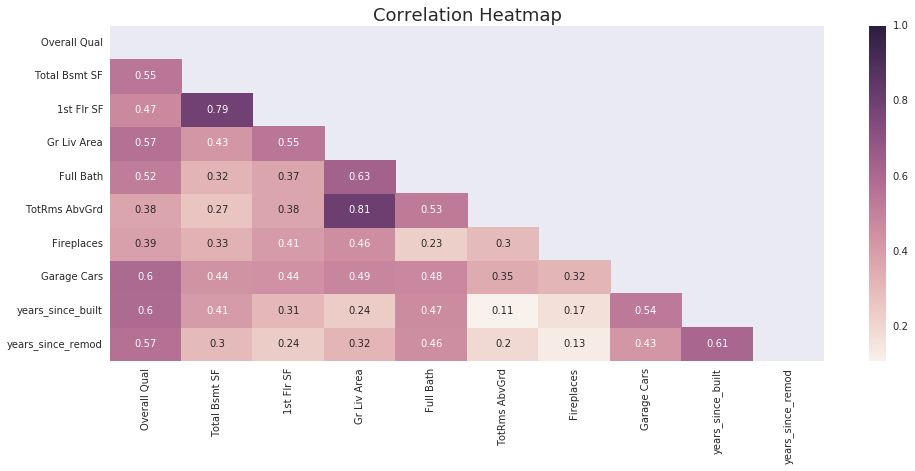

In [34]:
df_extended = unpivot(houses, 5)
df_filtered = select_features(df_extended, 0.4)
features = df_filtered.drop(columns='SalePrice')
df_features_corr = abs(features.corr())

plt.figure(figsize=(16, 6))
bool_mask = np.triu(np.ones_like(df_features_corr))
heatmap = sns.heatmap(df_features_corr, annot=True, mask=bool_mask)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':18})
plt.show()

We can see there are some features that highly correlated pairwise. We'll drop them

In [35]:
columns_to_drop = ['1st Flr SF', 'TotRms AbvGrd', 'years_since_built', 'Full Bath']
df_filtered_2 = df_filtered.drop(columns=columns_to_drop)
train_and_test(df_filtered_2)

(35163.222559848495, 1550.3735068800488)

Looks like it also doesn't help to increase the performance

## 6. Conclusion
We can't see how feature management can encrease the model's performance compared to the model based on all avaliable features, whereas I thought the idea of this project was to show how important it is to choose features smartly. 
Maybe there are some combinations of features which can encrease the performance of the model, but I didnt find them

I think it is about this particular dataset where the best performance reaches by using all the avaliable features